Inferring a 10-node network
===============

In [21]:
%matplotlib inline

In [22]:
from Swing import Swing
import pandas as pd

#optionally, for visualization
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

SWING (Sliding Window Inference for Network Generation) is a network inference tool implemented in python that incorporates elements from multivariate Granger causality and sliding window regression. This tutorial demonstrates how to infer a 10-node network using SWING-RF (RandomForest).

SWING has user-selected parameters that require knowledge of the system of interest. A more detailed discussion about setting these parameters and sensitivity of parameters is available in the Supporting Information of *Finkle et al (2018).*


## Step 0: examine/pre-process the input data-file.

SWING requires a $(m+1)$ x $(n+1)$ time-series gene expression dataset, where $m$ refers to the number of timepoints associated with each perturbation which populate each row, and $n$ refers to the number of genes which refers to each gene. It is expected that the first row will be the header row specifying the column/gene name labels (hence the +1). The first column should specify the time-point labels.

Our *in silico* dataset has 10 different sets of time-series for which a perturbation was applied and removed. Each time-series experiment has 21 timepoints. Gene expression was measured for 10 genes at 50 min intervals for 1000 min.

In [23]:
dataset = pd.read_csv('../data/Ecoli_10_node/Ecoli10-1_dream4_timeseries.tsv', sep='\t')
dataset.head()

,Time,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0,0.089284,0.270871,0.839036,0.200885,0.182632,0.356788,0.006343,0.599246,0.019762,0.033317
1,50,0.114581,0.318827,0.693707,0.142432,0.261206,0.198684,0.034523,0.640026,0.007827,0.034452
2,100,0.112723,0.393308,0.738423,0.073780,0.265523,0.057642,0.019089,0.664219,0.024778,0.047530
3,150,0.047108,0.369182,0.758015,0.066540,0.211461,0.015320,0.055761,0.627534,0.020925,0.025798
4,200,0.061564,0.342303,0.787797,0.082469,0.244511,0.004667,0.018079,0.713676,0.031663,0.031388


In [24]:
# 210 rows = 10 experiments * 21 timepoints each
# 10 gene columns + 1 time column
dataset.shape

(210, 11)

## Step 1: initialize a SWING object. 

**To generate a SWING object, we will specify the following parameters:**

- Inference-related parameters:
  - *min_lag* and *max_lag*: *min_lag* and *max_lag* refers to the allowed delay range (also known as $k_{min}$ and $k_{max}$). If *min_lag* = 1 and *max_lag* = 3, we are assuming the responses are delayed by at least one timepoint and at most 3 timepoints. We recommend you set values for *min_lag* and *max_lag* using prior knowledge or delay analysis using a subset of experimentally validated edges.  
  - *window_width*: the window size (also known as *w*). This value should be $1<w \leq T$ where $T$ refers to the number of timepoints in each perturbation. If *w* = $T$, then only 1 window will be created.
  - *window_type*: the embedded inference algorithm. Currently the three implemented algorithms are LASSO, RF, and PLSR. Depending on the algorithm you choose, you will also specify additional parameters.
- Data-parsing related parameters:
  - *gene_start_column*: the position of the first column with numerical expression data. This is 0-indexed, so if your first column denotes the timepoint labels and the second column contains numerical data, the gene_start_column should be 1.
  - *time_label*: the label of the time-point labels.
  - *separator*: the delimiter to use.
  - *gene_end*: the position of the last gene (0-indexed).
  - *file_path*: the file_path of the time-series data-file

In [25]:
# parsing-related parameters
gene_start_column = 1
time_label = "Time"
separator = "\t"
gene_end = None
file_path = "../data/Ecoli_10_node/Ecoli10-1_dream4_timeseries.tsv"

In [26]:
# inference related parameters
# k_min and k_max was determined using our cross-correlation analysis detailed in Finkle et al 2018.
# Sensitivity analysis of these parameters are also available in Supporting Information of Finkle et al 2018.
k_min = 1
k_max = 3
w = 10
method = 'RandomForest'

# random-forest specific parameter
trees = 100

In [27]:
sg = Swing(file_path, gene_start_column, gene_end, time_label, separator, min_lag=k_min, max_lag=k_max, window_width=w, window_type=method)

In [28]:
# Optionally, z-score the data. zscore_all_data() normalizes all the data by column (by gene).  
sg.zscore_all_data()

,Time,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0,-0.563726,-0.606203,1.228299,-0.558114,-0.922628,0.041356,-0.527995,-0.272521,-0.479344,-0.671869
1,50,0.024698,-0.223974,0.046455,-1.179870,-0.039325,-1.051685,-0.336545,0.221865,-1.159974,-0.630530
2,100,-0.018525,0.369675,0.410093,-1.910127,0.009209,-2.026762,-0.441405,0.515168,-0.193301,-0.154017
3,150,-1.544745,0.177383,0.569417,-1.987136,-0.598544,-2.319353,-0.192261,0.070426,-0.412980,-0.945839
4,200,-1.208491,-0.036860,0.811614,-1.817705,-0.227007,-2.393001,-0.448262,1.114764,0.199386,-0.742136
...,...,...,...,...,...,...,...,...,...,...,...
205,800,-0.489930,0.422353,0.419013,0.827494,0.415479,0.342655,-0.259271,0.875540,0.374526,-0.546858
206,850,-0.685166,0.071311,-0.398351,0.324308,-0.219049,0.350101,-0.373390,-0.345331,-0.173951,-0.349612
207,900,-0.381753,-0.259554,0.182480,0.434024,-0.307650,-0.189032,-0.455310,-0.919943,-0.398313,0.568248
208,950,-0.530694,-1.121127,1.611699,0.949935,-0.401332,0.167607,-0.462697,-0.813640,-0.423046,-0.836947


## Step 2: Partition data into windows.

Using the parameters we defined earlier (window_width, min_lag, max_lag...), we will partition the data into time-resolved subsets of data or "windows" using create_windows(). Our time-series dataset has 21 time-points and 10 perturbations. We specified a window size of 10, so total number of windows = (21 - 10 +1) = 12. 

SWING generates a number of models using windowed data. These models built with subsets of the data are later aggregated into a single model. Each model has a single response window (consisting of a subset of a time-series) and multiple explanatory windows (consisting of subsets of the explanatory data). 

Since we specified that min_lag = 1, and max_lag = 3, each response window is expected to have 3 explanatory windows that are lagging by 1 time-point, 2 time-points, and 3 time-points. **The first 3 response windows will not have sufficient explanatory data, and are removed from the window_list.**

Also, since $w=10$, it is expected that each window of data, $w_q$, will have 10 timepoints from each experiment.

In [29]:
sg.create_windows()

{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 3}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 4}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 5}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 6}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 7}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 8}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 9}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 10}
{'time_label': 'Time', 'gene_start': 1, 'gene_end': 11, 'nth_window': 11}


In [30]:
# window_list denotes only models/response windows with explanatory data
sg.window_list[0]

In [31]:
sg.window_list[0].earlier_windows

[0, 1, 2]

## Step 3: Initialize/Optimize Parameters for SWING.

For SWING-RF, this step will set the number of trees for each window to its default parameter. For other embedded algorithms such as SWING-PLSR, it will estimate optimal parameters for the inference algorithm of interest in the context of the data. This is discussed later in the tutorial.

In [32]:
sg.optimize_params()

In [33]:
sg.window_list[0].n_trees

500

## Step 4: Estimate edge importance for each window model.

Edge importance is estimated for each model using RandomForest and fit_windows(). Each model will output an estimated importance matrix denoting the importance or stability of each edge. For example, in SWING-RandomForest, the embedded inference algorithm is RandomForestRegression from scikit-learn, and feature\_importances\_ will be estimated for each edge.

In [34]:
#For the tutorial, we set the number of trees to 100. 
sg.fit_windows(n_trees=trees, show_progress=False, n_jobs=-1)

For each model, the feature importances between the explanatory data (G1-G10 from 3 different time-delayed windows; columns) to response data (G1-G10 response window; rows) are scored. Below is the raw version of the feature matrices we generate. We will compile the raw data into one dataframe in the next step.

In [35]:
sg.window_list[0].edge_importance

Parent,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
Child,,,,,,,,,,,,,,,,,,,,,
G1,0.057491,0.051730,0.046511,0.024360,0.008360,0.017964,0.019451,0.015411,0.015400,0.013775,...,0.112792,0.123032,0.055853,0.016534,0.016658,0.023360,0.021795,0.014729,0.008505,0.031588
G2,0.028834,0.057703,0.067596,0.010202,0.004084,0.006058,0.006871,0.009097,0.003322,0.010256,...,0.049620,0.159983,0.147231,0.023026,0.009959,0.005066,0.029393,0.045240,0.010725,0.026582
G3,0.021176,0.045878,0.063680,0.020412,0.017394,0.012928,0.009733,0.012828,0.012199,0.024435,...,0.023362,0.081976,0.170403,0.028628,0.036218,0.010672,0.013900,0.021272,0.026817,0.023956
G4,0.014934,0.018285,0.011634,0.110901,0.009717,0.013879,0.012894,0.010235,0.015536,0.009567,...,0.019519,0.030243,0.017707,0.230668,0.015440,0.033015,0.029873,0.024325,0.015402,0.017198
G5,0.017698,0.018827,0.033501,0.022312,0.082914,0.019614,0.014084,0.016332,0.018230,0.013053,...,0.018324,0.037160,0.062658,0.016059,0.168748,0.042584,0.021392,0.019887,0.024674,0.025721
G6,0.008725,0.013174,0.019987,0.059764,0.009588,0.128521,0.007883,0.006747,0.007073,0.013980,...,0.016310,0.029650,0.025345,0.037605,0.020518,0.178182,0.013880,0.014942,0.007361,0.017907
G7,0.032306,0.010526,0.002908,0.018793,0.007122,0.022690,0.143754,0.007218,0.004980,0.004311,...,0.060794,0.048361,0.010496,0.015941,0.005761,0.013621,0.188139,0.009591,0.007005,0.012487
G8,0.035626,0.033302,0.014237,0.046981,0.016023,0.017924,0.045028,0.014618,0.014955,0.019238,...,0.047666,0.052577,0.050500,0.032443,0.012115,0.015041,0.084575,0.051005,0.033405,0.015968
G9,0.013409,0.017490,0.033879,0.023737,0.014008,0.011351,0.011467,0.010007,0.077737,0.041083,...,0.017052,0.035045,0.015049,0.016145,0.060643,0.015528,0.014198,0.014241,0.138755,0.054114


## Step 5: Compile the all edges into one table

*compile_edges()* generates an aggregate edge table that summarizes the properties of each edge of each window.

In [36]:
sg.compile_edges()

Compiling all model edges...[DONE]


In [37]:
sg.full_edge_list

,Parent,Child,Importance,P_window,C_window,adj_imp,Rank,Edge,Lag
9,G3,G2,0.147231,2,3,0.147231,9,"(G3, G2)",1
14,G2,G1,0.123032,2,3,0.123032,14,"(G2, G1)",1
19,G2,G10,0.094848,0,3,0.094848,19,"(G2, G10)",3
20,G3,G2,0.093540,1,3,0.093540,20,"(G3, G2)",2
22,G3,G10,0.088647,0,3,0.088647,22,"(G3, G10)",3
...,...,...,...,...,...,...,...,...,...
2695,G6,G7,0.010959,9,11,0.010959,295,"(G6, G7)",2
2696,G3,G7,0.010084,10,11,0.010084,296,"(G3, G7)",1
2697,G3,G7,0.010048,8,11,0.010048,297,"(G3, G7)",3
2698,G5,G7,0.010044,10,11,0.010044,298,"(G5, G7)",1


## Step 6: Get Aggregate Model

We will generate an aggregate model by averaging the rank of each edge accross all windowed models. There are several options that allow you to specify whether the mean or median rank is selected and this is discussed in the documentations.

In [72]:
sg.make_static_edge_dict(self_edges=False, lag_method='mean_mean')
ranked_edges = sg.make_sort_df(sg.edge_dict)

Lumping edges...0 out of 90...[DONE]
Calculating mean edge importance...[DONE]


In [73]:
ranked_edges

,regulator-target,mean_importance
0,"(G3, G2)",0.083092
1,"(G2, G1)",0.071084
2,"(G2, G10)",0.064172
3,"(G2, G3)",0.056506
4,"(G3, G10)",0.056406
...,...,...
85,"(G9, G2)",0.012702
86,"(G8, G6)",0.012146
87,"(G7, G6)",0.010763
88,"(G3, G7)",0.010681


## Optional Step 7: Visualize network

We can use networkx to visualize the inferred network.

In [91]:
ranked_edges[['Source', 'Target']] = ranked_edges['regulator-target'].apply(pd.Series)
# set arbitrary cutoff to 20 edges
trunc_ranked_edges = ranked_edges.ix[0:15]
trunc_ranked_edges

,regulator-target,mean_importance,Source,Target
0,"(G3, G2)",0.083092,G3,G2
1,"(G2, G1)",0.071084,G2,G1
2,"(G2, G10)",0.064172,G2,G10
3,"(G2, G3)",0.056506,G2,G3
4,"(G3, G10)",0.056406,G3,G10
...,...,...,...,...
11,"(G3, G5)",0.042061,G3,G5
12,"(G2, G7)",0.041773,G2,G7
13,"(G1, G2)",0.037300,G1,G2
14,"(G4, G8)",0.037182,G4,G8


In [92]:
G = nx.DiGraph()
for index, row in trunc_ranked_edges.iterrows():
    G.add_edge(row['Source'], row['Target'])

{'G1': Text(-25.0788,33.7245,'G1'),
 'G10': Text(69.5195,-46.321,'G10'),
 'G2': Text(6.20793,18.6342,'G2'),
 'G3': Text(27.0781,11.3467,'G3'),
 'G4': Text(-52.611,-25.6457,'G4'),
 'G5': Text(33.1733,63.5481,'G5'),
 'G6': Text(-47.7731,-100,'G6'),
 'G7': Text(-37.1908,40.7323,'G7'),
 'G8': Text(-56.9153,49.0383,'G8'),
 'G9': Text(83.5901,-45.0574,'G9')}

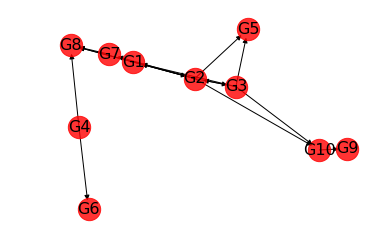

In [93]:
pos=nx.spring_layout(G, scale=100)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_color='r',node_size=500,alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=1)
nx.draw_networkx_labels(G,pos,font_size=16)

## Optional Step 8: Score Network (if gold standard is available)

The Swing object has a built-in method for scoring models.

In [94]:
gold_standard_file = "../data/Ecoli_10_node/Ecoli10-1_goldstandard.tsv"
roc_dict, pr_dict = sg.score(ranked_edges, gold_standard_file=gold_standard_file)
print('AUROC:', roc_dict['auroc'][-1])
print('AUPR:', pr_dict['aupr'][-1])

Scoring model...[DONE]
AUROC: 0.7937777777777767
AUPR: 0.4378104716073147
